In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from datetime import datetime
np.warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from skimage.transform import resize
os.listdir('./')


ModuleNotFoundError: No module named 'sklearn'

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
from datetime import datetime
os.listdir('./')

['trainset.csv',
 'outnum.dat',
 'rsf0_regimes.ipynb',
 'RSF.m',
 '.DS_Store',
 'repeattest.csv',
 'rsf0_rupture.ipynb',
 'rsf0_test.csv',
 'data_output3.npy',
 'data_output2.npy',
 'data_output0.npy',
 'comparison2d.cpp',
 'lsw0_test.csv',
 'data_output1.npy',
 'data_output5.npy',
 'rsf_trainset.csv',
 'data_output4.npy',
 'data_output6.npy',
 'data_output7.npy',
 'err.txt',
 'data_output10.npy',
 'data_output9.npy',
 'rsf2d_qd_Loes_bc_corrected.m',
 'data_output8.npy',
 'valinum.dat',
 'LSW.m',
 'test.m',
 '.ipynb_checkpoints',
 'vali.csv',
 'hamed3d.cpp',
 'dataset.csv',
 'bisection.m',
 'datagener.sh']

In [4]:
total_df=pd.read_csv('./rsf0_test.csv')
total_df

,group_id,a,b,L,t,dt,theta,tau,U,V
0,1,0.008333,0.023565,0.024865,0.001200,0.001200,2.486430e+07,41.0169,0.000001,0.00100
1,1,0.008333,0.023565,0.024865,0.002640,0.001440,2.486280e+07,41.0168,0.000003,0.00100
2,1,0.008333,0.023565,0.024865,0.004368,0.001728,2.486110e+07,41.0167,0.000004,0.00100
3,1,0.008333,0.023565,0.024865,0.006442,0.002074,2.485900e+07,41.0166,0.000006,0.00100
4,1,0.008333,0.023565,0.024865,0.008930,0.002488,2.485650e+07,41.0164,0.000009,0.00100
...,...,...,...,...,...,...,...,...,...,...
4999995,500,0.007792,0.025870,0.024865,14.507600,0.000593,4.479390e-03,15.9629,32.793500,5.55093
4999996,500,0.007792,0.025870,0.024865,14.508200,0.000593,4.479410e-03,15.9629,32.796800,5.55091
4999997,500,0.007792,0.025870,0.024865,14.508800,0.000593,4.479430e-03,15.9629,32.800100,5.55089
4999998,500,0.007792,0.025870,0.024865,14.509400,0.000593,4.479440e-03,15.9629,32.803400,5.55087


In [ ]:
# Preprocessing the Data
# 1. add_features : first with dV -- criteria for rupture process
# 2. Use dV <= -0.01 to cut the series into three segments : Pay main focus on the second seg.
# 2.1 Describe the whole series with 4 t: t0(start), t1(regime1 stop and regime2 start), 
#     t2(regime2 stop and regime3 start), t3(stop)
# 3. Add more features for each segments 
# 3.1 Most important : if Not 等间隔 --> Resample and Interpolate

In [15]:
class Datasample():
    def __init__(self, df):
        self.df=df
    
    def add_features(self, Nt):
        #Eliminate unreal data
        id_idx=self.df.loc[(self.df['V']<=0.0), 'group_id'].unique()
        self.df=self.df[~self.df['group_id'].isin(id_idx)]
        #Eliminate double V forks
        #Eliminate very long rupture process

        self.df['tau_lag']=self.df.groupby(self.df['group_id'])['tau'].shift(1)
        self.df['V_lag']=self.df.groupby(self.df['group_id'])['V'].shift(1)
        self.df['dtau']=self.df['tau_lag']-self.df['tau']
        self.df['dV']=self.df['V_lag']-self.df['V']
        self.df['dtau/dt']=self.df['tau']/self.df['dt']
        self.df=self.df.fillna(0)

        start_datetime=datetime.now()
        groups=len(self.df.group_id.unique())
        N=[]
        df_new=pd.DataFrame()
        for i in range(groups):
            df_group=self.df.iloc[Nt*i : Nt*(i+1)]

            start_t=df_group[df_group['dtau/dt'] >= 1].iloc[0,4]
            stop_t=df_group[df_group['dtau/dt'] >= 1].iloc[-1,4]

            df_group=df_group.loc[df_group[df_group.t >= start_t].index.tolist()[0] :
                                  df_group[df_group.t >= stop_t].index.tolist()[0]]

            if df_group.iloc[int(df_group.shape[0]/3):int(df_group.shape[0]/2), -3].any() == 0.0\
            or df_group.iloc[int(df_group.shape[0]/2):int(2*df_group.shape[0]/3), -3].any() ==0.0:
                print(df_group.group_id.unique())
                continue

            if (df_group.iloc[30,-2]*df_group.iloc[31,-2]) <0 or (df_group.iloc[53,-2]*df_group.iloc[54,-2]) <0:
                print(df_group.group_id.unique())
                continue

            df_group=df_group[['group_id', 'a', 'b', 'L', 't', 'theta', 'U', 'V', 'tau']]
      
            #Resample
            df_group['t']=pd.to_timedelta(df_group['t'], unit='s')
            df_group.set_index('t', inplace=True)
            df_group=df_group.resample('10ms').mean().interpolate().reset_index(drop=False)
            df_group.t=df_group['t'].dt.total_seconds()
            num_points=df_group.shape[0]
            N.append(num_points)

            df_group['dtau']=df_group['tau'].shift(1)-df_group['tau']
            df_group['dtau2']=df_group['tau'].shift(2)-df_group['tau']
            df_group['dV']=df_group['V'].shift(1)-df_group['V']
            df_group['dV2']=df_group['V'].shift(2)-df_group['V']
            df_group['dU']=df_group['U'].shift(1)-df_group['U']
            df_group['dU2']=df_group['U'].shift(2)-df_group['U']
            df_group['dtheta']=df_group['theta'].shift(1)-df_group['theta']
            df_group['dtheta2']=df_group['theta'].shift(2)-df_group['theta']
            df_group=df_group.fillna(0)

            df_new=df_new.append(df_group)

        self.df=df_new[['group_id','a','b','L','dtau','dtau2','theta','dtheta',
                        'dtheta2','U','dU','dU2','V','dV','dV2','t','tau']]
        #group_df=self.df.groupby('group_id')
        #N=group_df.size().to_numpy()
        print(datetime.now()-start_datetime)
        return self.df, N


In [ ]:
Nt=10000
df,N=Datasample(total_df).add_features(Nt)
print(len(N))
df

In [13]:
print(500*Nt-14459339)

-13559339


In [ ]:
class Datasample():
  def __init__(self, df):
    self.df=df

  def add_features(self, Nt):
    #Eliminate unreal data
    id_idx=self.df.loc[(self.df['V']<=0.0), 'group_id'].unique()
    self.df=self.df[~self.df['group_id'].isin(id_idx)]
    #Eliminate double V forks
    #Eliminate very long rupture process

    self.df['tau_lag']=self.df.groupby(self.df['group_id'])['tau'].shift(1)
    self.df['V_lag']=self.df.groupby(self.df['group_id'])['V'].shift(1)
    self.df['dtau']=self.df['tau_lag']-self.df['tau']
    self.df['dV']=self.df['V_lag']-self.df['V']
    self.df['dtau/dt']=self.df['dtau']/self.df['dt']
    self.df=self.df.fillna(0)

    start_datetime=datetime.now()
    groups=len(self.df.group_id.unique())
    #N=[]
    df_new=pd.DataFrame()
    for i in range(groups):
      df_group=self.df.iloc[Nt*i : Nt*(i+1)]

      start_t=df_group[df_group['dtau/dt'] >= 1].iloc[0,4]
      stop_t=df_group[df_group['dtau/dt'] >= 1].iloc[-1,4]

      df_group=df_group.loc[df_group[df_group.t == start_t].index.tolist()[0] :
                            df_group[df_group.t == stop_t].index.tolist()[0]]

      if df_group.iloc[int(df_group.shape[0]/3):int(df_group.shape[0]/2), -3].any() ==0.0\
      or df_group.iloc[int(df_group.shape[0]/2):int(2*df_group.shape[0]/3), -3].any() ==0.0:
        print('too long time to rupture')
        print(df_group.group_id.unique())
        continue
      #print(df_group.iloc[0,-2]*df_group.iloc[1,-2])
      if (df_group.iloc[30,-2]*df_group.iloc[31,-2]) <=0\
       or (df_group.iloc[53,-2]*df_group.iloc[54,-2]) <=0\
       or (df_group.iloc[74,-2]*df_group.iloc[75,-2]) <=0:
        print('double fork V')
        print(df_group.group_id.unique())
        continue

      df_group=df_group[['group_id', 'a', 'b', 'L', 't', 'theta', 'U', 'V', 'tau']]
      
      #Resample
      df_group['t']=pd.to_timedelta(df_group['t'], unit='s')
      df_group.set_index('t', inplace=True)
      df_group=df_group.resample('10ms').mean().interpolate().reset_index(drop=False)
      df_group.t=df_group['t'].dt.total_seconds()
      #num_points=df_group.shape[0]
      #N.append(num_points)

      df_group['dtau']=df_group['tau'].shift(1)-df_group['tau']
      df_group['dtau2']=df_group['tau'].shift(2)-df_group['tau']
      df_group['dV']=df_group['V'].shift(1)-df_group['V']
      df_group['dV2']=df_group['V'].shift(2)-df_group['V']
      df_group['dU']=df_group['U'].shift(1)-df_group['U']
      df_group['dU2']=df_group['U'].shift(2)-df_group['U']
      df_group['dtheta']=df_group['theta'].shift(1)-df_group['theta']
      df_group['dtheta2']=df_group['theta'].shift(2)-df_group['theta']
      df_group=df_group.fillna(0)

      #if df_group.shape[0] > 100000:
        #print('too much samples_too long time')
        #print(df_group.group_id.unique())
        #continue


      df_new=df_new.append(df_group)

    self.df=df_new[['group_id','a','b','L','dtau','dtau2','theta','dtheta',
                      'dtheta2','U','dU','dU2','V','dV','dV2','t','tau']]
    group_df=self.df.groupby('group_id')
    N=group_df.size().tolist()
    print(datetime.now()-start_datetime)
    return self.df, N


In [ ]:
Nt=10000
df,N=Datasample(total_df).add_features(Nt)
print(len(N))
df

In [ ]:
#From eejit

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
from datetime import datetime
np.warnings.filterwarnings('ignore')
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import OneHotEncoder
#from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.listdir('./')

['trainset.csv',
 'outnum.dat',
 'rsf0_regimes.ipynb',
 'RSF.m',
 '.DS_Store',
 'repeattest.csv',
 'rsf0_rupture.ipynb',
 'rsf0_test.csv',
 'data_output3.npy',
 'data_output2.npy',
 'data_output0.npy',
 'comparison2d.cpp',
 'lsw0_test.csv',
 'data_output1.npy',
 'data_output5.npy',
 'rsf_trainset.csv',
 'data_output4.npy',
 'data_output6.npy',
 'data_output7.npy',
 'err.txt',
 'data_output10.npy',
 'data_output9.npy',
 'rsf2d_qd_Loes_bc_corrected.m',
 'data_output8.npy',
 'valinum.dat',
 'LSW.m',
 'test.m',
 '.ipynb_checkpoints',
 'vali.csv',
 'hamed3d.cpp',
 'dataset.csv',
 'bisection.m',
 'datagener.sh']

In [2]:
total_df=pd.read_csv('./rsf0_test.csv')
total_df

,group_id,a,b,L,t,dt,theta,tau,U,V
0,1,0.008333,0.023565,0.024865,0.001200,0.001200,2.486430e+07,41.0169,0.000001,0.00100
1,1,0.008333,0.023565,0.024865,0.002640,0.001440,2.486280e+07,41.0168,0.000003,0.00100
2,1,0.008333,0.023565,0.024865,0.004368,0.001728,2.486110e+07,41.0167,0.000004,0.00100
3,1,0.008333,0.023565,0.024865,0.006442,0.002074,2.485900e+07,41.0166,0.000006,0.00100
4,1,0.008333,0.023565,0.024865,0.008930,0.002488,2.485650e+07,41.0164,0.000009,0.00100
...,...,...,...,...,...,...,...,...,...,...
4999995,500,0.007792,0.025870,0.024865,14.507600,0.000593,4.479390e-03,15.9629,32.793500,5.55093
4999996,500,0.007792,0.025870,0.024865,14.508200,0.000593,4.479410e-03,15.9629,32.796800,5.55091
4999997,500,0.007792,0.025870,0.024865,14.508800,0.000593,4.479430e-03,15.9629,32.800100,5.55089
4999998,500,0.007792,0.025870,0.024865,14.509400,0.000593,4.479440e-03,15.9629,32.803400,5.55087


In [6]:
class Datasample():
    def __init__(self, df):
        self.df=df
    def add_features(self, Nt):
        #Eiliminate unreal data
        id_idx=self.df.loc[(self.df['V']<=0.0), 'group_id'].unique()
        self.df=self.df[~self.df['group_id'].isin(id_idx)]
        
        self.df['tau_lag']=self.df.groupby(self.df['group_id'])['tau'].shift(1)
        self.df['V_lag']=self.df.groupby(self.df['group_id'])['V'].shift(1)
        self.df['dtau']=self.df['tau_lag']-self.df['tau']
        self.df['dV']=self.df['V_lag']-self.df['V']
        self.df['dtau/dt']=self.df['dtau']/self.df['dt']
        self.df=self.df.fillna(0)
        
        start_datetime=datetime.now()
        groups=len(self.df.group_id.unique())
        df_new=pd.DataFrame()
        for i in range(groups):
            df_group=self.df.iloc[Nt*i : Nt*(i+1)]
            
            start_t=df_group[df_group['dtau/dt'] >=1].iloc[0,4]
            stop_t=df_group[df_group['dtau/dt']>=1].iloc[-1,4]
            df_group=df_group.loc[df_group[df_group.t == start_t].index.tolist()[0] :
                                  df_group[df_group.t == stop_t].index.tolist()[0]]
            #Eliminate double fork V
            if (df_group.iloc[10,-2]*df_group.iloc[11,-2]) <=0\
            or (df_group.iloc[33,-2]*df_group.iloc[34,-2]) <=0\
            or (df_group.iloc[54,-2]*df_group.iloc[55,-2]) <=0:
                continue
            
            df_group=df_group[['group_id','a','b','L','t','theta','U','V','tau']]
            #Resample
            df_group['t']=pd.to_timedelta(df_group['t'], unit='s')
            df_group.set_index('t', inplace=True)
            df_group=df_group.resample('1ms').mean().interpolate('linear').reset_index(drop=False)
            df_group.t=df_group['t'].dt.total_seconds()
            
            #New features
            df_group['dtau']=df_group['tau'].shift(1)-df_group['tau']
            df_group['dtau2']=df_group['tau'].shift(2)-df_group['tau']
            df_group['dV']=df_group['V'].shift(1)-df_group['V']
            df_group['dV2']=df_group['V'].shift(1)-df_group['V']
            df_group['dU']=df_group['U'].shift(1)-df_group['U']
            df_group['dU2']=df_group['U'].shift(2)-df_group['U']
            df_group['dtheta']=df_group['theta'].shift(1)-df_group['theta']
            df_group['dtheta2']=df_group['theta'].shift(2)-df_group['theta']
            df_group=df_group.fillna(0)
            
            #Eliminate too much time to rupture
            if df_group.shape[0]>20000:
                continue
            df_new=df_new.append(df_group)
        self.df=df_new[['group_id','a','b','L','dtau','dtau2','theta','dtheta','dtheta2','U','dU','dU2','V',
                        'dV','dV2','tau']]
        N=self.df.groupby('group_id').size().tolist()
        print(datetime.now()-start_datetime)
        return self.df, N
    
    def split_df(self, N):
        #Split the data_df into train:val:test=7:2:1 with 'group_id's
        #And not shuffle when spliting df --> make series dataset
        num_columns=self.df.shape[-1]
        column_indices={name: i for i, name in enumerate(self.df.columns)}
        
        N_new=np.zeros(len(N), dtype=int)
        for i in range(len(N)):
            if i==0:
                N_new[i]=N[i]
            else:
                N_new[i]=N[i]+N_new[i-1]
        N[:]=N_new[:]
        
        test_groups=int(len(N)*1/10)
        val_groups=int(len(N)*2/10)
        train_groups=len(N)-test_groups-val_groups
        train_num=train_groups-1
        val_num=train_groups+val_groups-1
        
        train_df=self.df.iloc[0:N[train_num], :]
        val_df=self.df.iloc[N[train_num]:N[val_num], :]
        test_df=self.df.iloc[N[val_num]:, :]
        return train_df, val_df, test_df, N
    
    def normalization(self, train_df, val_df, test_df):
        train_mean=train_df.mean()
        train_std=train_df.std()
        if abs(train_std['a'])<1e-10:
            train_std['a']=1.0
        if abs(train_std['b'])<1e-10:
            train_std['b']=1.0
        if abs(train_std['L'])<1e-10:
            train_std['L']=1.0
        
        train_df_nor=(train_df - train_mean) / train_std
        val_df_nor=(val_df - train_mean) / train_std
        test_df_nor=(test_df - train_mean) / train_std
        return train_df_nor, val_df_nor, test_df_nor, train_mean, train_std

In [7]:
Nt=10000
df,N=Datasample(total_df).add_features(Nt)
num_columns=df.shape[-1]
column_indices={name: i for i, name in enumerate(df.columns)}
print(num_columns)
print(column_indices)
#print(N)
train_df, val_df, test_df, N=Datasample(df).split_df(N)
print(f'train_df.shape={train_df.shape}')
print(f'val_df.shape={val_df.shape}')
print(f'test_df.shape={test_df.shape}')
#print(N)

train_df_nor, val_df_nor, test_df_nor, train_mean, train_std=Datasample(df).normalization(train_df, val_df, test_df)
print(f'train_df_nor.shape = {train_df_nor.shape}')
print(f'val_df_nor.shape = {val_df_nor.shape}')
print(f'test_df_nor.shape = {test_df_nor.shape}')
print(f'train_mean = {train_mean}')
print(f'train_std = {train_std}')

0:00:10.072917
16
{'group_id': 0, 'a': 1, 'b': 2, 'L': 3, 'dtau': 4, 'dtau2': 5, 'theta': 6, 'dtheta': 7, 'dtheta2': 8, 'U': 9, 'dU': 10, 'dU2': 11, 'V': 12, 'dV': 13, 'dV2': 14, 'tau': 15}
train_df.shape=(141883, 16)
val_df.shape=(38134, 16)
test_df.shape=(15422, 16)
train_df_nor.shape = (141883, 16)
val_df_nor.shape = (38134, 16)
test_df_nor.shape = (15422, 16)
train_mean = group_id    1.933199e+02
a           5.913354e-03
b           1.823267e-02
L           2.486550e-02
dtau        2.870546e-02
dtau2       5.740636e-02
theta       1.184042e+06
dtheta      9.021068e+03
dtheta2     1.801204e+04
U           2.943187e-01
dU         -1.560102e-03
dU2        -3.114051e-03
V           1.553756e+00
dV         -6.293405e-03
dV2        -6.293405e-03
tau         3.101229e+01
dtype: float64
train_std = group_id    1.056635e+02
a           2.764323e-03
b           4.685324e-03
L           1.000000e+00
dtau        5.318608e-02
dtau2       1.052938e-01
theta       2.395685e+06
dtheta      1.64781

In [90]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, label_columns=None):
        self.train_df=train_df
        self.val_df=val_df
        self.test_df=test_df
        self.label_columns=label_columns
        if label_columns is not None:
            self.label_columns_indices={name: i for i,name in enumerate(self.label_columns)}
        self.column_indices={name: i for i,name in enumerate(self.train_df.columns)}
        self.input_width=input_width
        self.label_width=label_width
        self.shift=shift
        self.total_window_size=input_width+shift
        
        self.input_slice=slice(0,input_width)
        self.input_indices=np.arange(self.total_window_size)[self.input_slice]
        self.label_start=self.total_window_size-self.label_width
        self.label_slice=slice(self.label_start, None)
        self.label_indices=np.arange(self.total_window_size)[self.label_slice]
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs=features[:,self.input_slice,:]
        labels=features[:,self.label_slice,:]
        if self.label_columns is not None:
            labels=tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])
        return inputs,labels
    def make_dataset(self, data, batch_size, is_training=False):
        start_datetime=datetime.now()
        N=data.groupby('group_id').count()['a'].to_numpy()
        groups=len(N)
        N_new=np.zeros((groups), dtype=int)
        for i in range(groups):
            if i==0:
                N_new[i]=N[i]
            else:
                N_new[i]=N[i]+N_new[i-1]
        for i in range(groups):
            if i==0:
                data_group=data[0:N_new[0]].to_numpy()
                if is_training:
                    ds=self.shuffle_timeseries(data_group, batch_size)
                else:
                    ds=self.not_shuffle_timeseries(data_group, batch_size)
                dsset=ds
            else:
                data_group=data[N_new[i-1]:N_new[i]].to_numpy()
                if is_training:
                    ds=self.shuffle_timeseries(data_group, batch_size)
                else:
                    ds=self.not_shuffle_timeseries(data_group, batch_size)       
                dsset=dsset.concatenate(ds)
        dsset=dsset.map(self.split_window)
        print(datetime.now()-start_datetime)
        return dsset
    def shuffle_timeseries(self, data, batch_size):
        ds=timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True, #Shuffle train and val
            batch_size=batch_size)
        return ds
    def not_shuffle_timeseries(self, data, batch_size):
        ds=timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False, #Not shuffle the test
            batch_size=batch_size)
        return ds

In [91]:
# Generate multi_window
batch_size=256
out_step=25
multi_window=WindowGenerator(input_width=25, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)
for example_multi_inputs, example_multi_labels in multi_window_train.take(1):
    print(f'Inputs shape (batch, time, features): {example_multi_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_multi_labels.shape}')

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:06.329488
0:00:01.469439
0:00:01.148629
16
Inputs shape (batch, time, features): (256, 25, 16)
Labels shape (batch, time, features): (256, 25, 1)


In [147]:
#Create a Baseline --> a linear function
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

In [186]:
def abl_tau(df):
    labels=pd.DataFrame()
    labels[['a','b','L']]=df.groupby('group_id').apply(lambda x: x.iloc[0,1:4])
    targets=pd.DataFrame()
    targets['tau_min']=df.groupby('group_id').apply(lambda x: x.min()['tau'])
    targets['tau_max']=df.groupby('group_id').apply(lambda x: x.max()['tau'])
    return labels, targets

abl, tau=abl_tau(df)
abl_train, abl_test, tau_train, tau_test = train_test_split(abl, tau, test_size=0.1)

tau_model=LinearRegression()
tau_model.fit(abl_train, tau_train)
tau_model_score=tau_model.score(abl_test, tau_test)
tau_pred=tau_model.predict(abl_test)
tau_model_loss=mean_squared_error(tau_test, tau_pred)
print(f'tau_Linear_mse: {tau_model_loss}')
print(f'tau_Linear_accuracy: {tau_model_score}')

tau_Linear_mse: 0.0019975391912088127
tau_Linear_accuracy: 0.9997376263978621


In [209]:
train_df.group_id.unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50., 103., 106., 107., 108., 111.,
       114., 116., 117., 128., 130., 133., 135., 138., 141., 142., 145.,
       146., 147., 151., 152., 153., 154., 155., 156., 157., 158., 159.,
       160., 161., 162., 163., 164., 165., 166., 167., 168., 169., 170.,
       171., 172., 173., 174., 175., 176., 177., 178., 179., 180., 181.,
       182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192.,
       193., 194., 195., 196., 197., 198., 199., 200., 201., 202., 203.,
       204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214.,
       215., 216., 217., 218., 219., 220., 221., 222., 223., 224., 225.,
       226., 227., 228., 229., 230., 231., 232., 23

In [225]:
def normalization(data,train_mean=train_mean, train_std=train_std):
  norm_tau=(data-train_mean.tau)/train_std.tau
  return norm_tau
groups=train_df.group_id.unique()
Baseline_loss=np.empty(len(groups))
nor_baseline_loss=np.empty(len(groups))
train_df[train_df['group_id']==1]
labels=[]
for i in range(len(groups)):
    i=groups[i]
    abl=train_df[train_df['group_id']==i].iloc[0,1:4].to_list()
    labels.append(abl)
tau=np.empty((len(groups),2))
pred_tau=tau_model.predict(labels) #[taumin,taumax]
for i in range(len(groups)):
    j=groups[i]
    t_end=len(train_df[train_df['group_id']==j])
    t=train_df[train_df['group_id']==j].index.to_numpy()
    true_tau=train_df[train_df['group_id']==j].iloc[:,-1].to_numpy()
    baseline_tau=np.arange(0,t_end,1)
    for n in range(t_end):
        baseline_tau[n]=(t[n]-t_end)*(tau[i,-1]-tau[i,0])/(-t_end)+tau[i,0]
    Baseline_loss[i]=((true_tau-baseline_tau)**2).mean(axis=None)
    nor_baseline_loss[i]=((normalization(true_tau)-normalization(baseline_tau))**2).mean(axis=None)
loss=np.mean(Baseline_loss)
nor_loss=np.mean(nor_baseline_loss)
print(f'Baseline_mse_loss: {loss}')
print(f'Normalization_Baseline_mse_loss: {nor_loss}')

Baseline_mse_loss: 1016.9563737247869
Normalization_Baseline_mse_loss: 16.31900083415029


In [96]:
def compile_and_fit(model,max_epochs, window_train,window_val,window_test, patience=2):
    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
    model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[MeanAbsoluteError()])
    history=model.fit(window_train, epochs=max_epochs,
                    validation_data=window_val,
                    callbacks=[early_stopping])
    return history

# Build model
# Dense
def multi_dense_model(out_step, num_features):
    model=Sequential(
      [#Shape [batch, point, features] --> [batch, 1, features] take the last point
       layers.Lambda(lambda x: x[:,-1:,:]),
       layers.Dense(units=512, activation='relu'),
       layers.Dense(units=out_step*num_features,
                    kernel_initializer=tf.initializers.zeros()),
       layers.Reshape([out_step, num_features])])
    return model

# Conv
def multi_conv_model(out_step, num_features, multi_conv_width):
    model=Sequential(
      [layers.Lambda(lambda x: x[:,-multi_conv_width:,:]),
       layers.Conv1D(filters=256, kernel_size=(multi_conv_width,), activation='relu'),
       layers.Dense(units=out_step*num_features,
                    kernel_initializer=tf.initializers.zeros()),
       layers.Reshape([out_step, num_features])])
    return model


In [97]:
# Training process, give epochs(combined with batch_size)
multi_conv_width=25
max_epochs=10

#for tau prediction, the num_features is 1
multi_dense=multi_dense_model(out_step, 1)
multi_conv=multi_conv_model(out_step, 1, multi_conv_width)

print('Multi Dense')
history=compile_and_fit(multi_dense, max_epochs, multi_window_train, multi_window_val, multi_window_test)
print(multi_dense.summary())
val_performance={}
performance={}
#multi_window.plot(batch_size,N, plot_col=['tau'],model=multi_dense)
val_performance['Multi_Dense']=multi_dense.evaluate(multi_window_test)
performance['Multi_Dense']=multi_dense.evaluate(multi_window_test)
print('Multi Conv')
history=compile_and_fit(multi_conv, max_epochs, multi_window_train, multi_window_val, multi_window_test)
print(multi_conv.summary())
#multi_window.plot(batch_size,N, plot_col=['tau'],model=multi_conv)
val_performance['Multi_Conv']=multi_conv.evaluate(multi_window_test)
performance['Multi_Conv']=multi_conv.evaluate(multi_window_test)
#Conv is better than Dense

Multi Dense
Epoch 1/10
630/630 [==============================] - 12s 18ms/step - loss: 0.0369 - mean_absolute_error: 0.0738 - val_loss: 0.0137 - val_mean_absolute_error: 0.0530
Epoch 2/10
630/630 [==============================] - 10s 16ms/step - loss: 0.0024 - mean_absolute_error: 0.0304 - val_loss: 0.0086 - val_mean_absolute_error: 0.0478
Epoch 3/10
630/630 [==============================] - 11s 18ms/step - loss: 0.0026 - mean_absolute_error: 0.0296 - val_loss: 0.0067 - val_mean_absolute_error: 0.0411
Epoch 4/10
630/630 [==============================] - 11s 18ms/step - loss: 0.0023 - mean_absolute_error: 0.0262 - val_loss: 0.0062 - val_mean_absolute_error: 0.0384
Epoch 5/10
630/630 [==============================] - 12s 20ms/step - loss: 0.0016 - mean_absolute_error: 0.0220 - val_loss: 0.0056 - val_mean_absolute_error: 0.0333
Epoch 6/10
630/630 [==============================] - 12s 19ms/step - loss: 0.0020 - mean_absolute_error: 0.0219 - val_loss: 0.0055 - val_mean_absolute_error:

In [141]:
def plot(self, batch_size, plot_col, model=None, max_subplot=4, train_mean=train_mean, train_std=train_std):
    for nor_inputs, nor_labels in self.make_dataset(self.test_df,batch_size).take(1):
        inputs=(nor_inputs*train_std)+train_mean
        labels=(nor_labels*train_std[plot_col])+train_mean[plot_col]
    if model is not None:
        nor_preds=model(nor_inputs)
        preds=(nor_preds*train_std[plot_col])+train_mean[plot_col]
    plt.figure(figsize=(12,8))
    plot_col_index=self.column_indices[plot_col]
    for n in range(max_subplot):
        #4 subplots : start+middle continue+end
        if n==0:
            plt.subplot(max_subplot, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs n=startpoint', marker='.',zorder=-10)
            label_col_index=self.label_columns_indices.get(plot_col, None)
            plt.scatter(self.label_indices, labels[n,:,label_col_index],
                        edgecolors='k', label='Targets', c='g',s=64)
            if model is not None:
                plt.scatter(self.label_indices, preds[n,:,label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='r',s=64)               
        elif n==1:
            plt.subplot(max_subplot, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[int(batch_size/2),:,plot_col_index],
                     label='Inputs n=%i' %(int(batch_size/2)), marker='.', zorder=-10)
            label_col_index=self.label_columns_indices.get(plot_col, None)
            plt.scatter(self.label_indices, labels[int(batch_size/2),:,label_col_index],
                        edgecolors='k', label='Targets', c='g',s=64)
            if model is not None:
                plt.scatter(self.label_indices, preds[int(batch_size/2),:,label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='r',s=64)                 
        elif n==2:
            plt.subplot(max_subplot, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[int(batch_size/2)+1,:,plot_col_index],
                     label='Inputs n=%i' %(int(batch_size/2)+1), marker='.', zorder=-10)
            label_col_index=self.label_columns_indices.get(plot_col, None)
            plt.scatter(self.label_indices, labels[int(batch_size/2)+1,:,label_col_index],
                        edgecolors='k', label='Targets', c='g',s=64)
            if model is not None:
                plt.scatter(self.label_indices, preds[int(batch_size/2)+1,:,label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='r',s=64)             
        elif n==3:
            plt.subplot(max_subplot, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[-1,:,plot_col_index],
                     label='Inputs n=endpoint', marker='.', zorder=-10)
            label_col_index=self.label_columns_indices.get(plot_col, None)
            plt.scatter(self.label_indices, labels[-1,:,label_col_index],
                        edgecolors='k', label='Targets', c='g',s=64)
            if model is not None:
                plt.scatter(self.label_indices, preds[-1,:,label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='r',s=64)             

        plt.legend()
    plt.xlabel('time(ms)')
    
WindowGenerator.plot=plot


0:00:01.059971


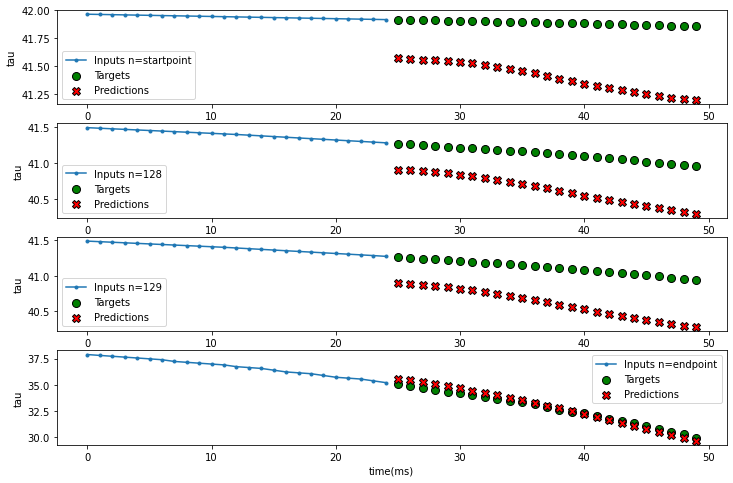

In [142]:
multi_window.plot(batch_size,plot_col='tau',model=multi_dense)

In [ ]:
def plot(self, batch_size, N, plot_col, model=None, max_subplot=2, train_mean=train_mean, train_std=train_std):
    #instead of train_df.dataset-->test_df.dataset is for evaluation
    for example_inputs, example_labels in self.make_dataset(self.test_df,batch_size,N).take(1):
      inputs=(example_inputs*train_std)+train_mean
      labels=(example_labels*train_std[plot_col])+train_mean[plot_col]
      #From make_dataset(),already shuffled the outputs examples
    plt.figure(figsize=(12,8))
    #plot_col_index=self.column_indices[plot_col]
    max_n=min(max_subplot, len(inputs))

    if len(plot_col)==1:
      plot_col_index=self.column_indices[plot_col[0]]
      plot_point=[]
      for n in range(max_n):
      #For clear show, plot 'dtau/dt'>>0
        for j in range(batch_size):
          if inputs[j,-1,6]>1:
            plot_point.append(j)

        plt.subplot(max_n,1,n+1)
        plt.ylabel(f'{plot_col}')
        plt.plot(self.input_indices,inputs[plot_point[n+30], : ,plot_col_index],
                label='Inputs n=%i' %(plot_point[n+30]), marker='.',zorder=-10)  

        label_col_index=self.label_columns_indices.get(plot_col[0],None)

        plt.scatter(self.label_indices, labels[plot_point[n+30],:,label_col_index],
                    edgecolors='k', label='Targets',c='g', s=64)
        if model is not None:
          inputs_normalized=(inputs-train_mean)/train_std
          predictions=model(inputs_normalized)
        #predictions=model(inputs)
          predictions=(predictions*train_std[plot_col])+train_mean[plot_col]
          plt.scatter(self.label_indices, predictions[plot_point[n+30],:,label_col_index],
                      marker='X', edgecolors='k', label='Predictions', c='r', s=64)
        plt.legend()
      plt.xlabel('Points Previous')
    elif len(plot_col) > 1:
      plot_col_index_y=self.column_indices[plot_col[0]] #==16.
      plot_col_index_x=self.column_indices[plot_col[1]] #==3.
      plot_point=[]
      for n in range(max_n):
      #For clear show, plot 'dtau/dt'>>0
        for j in range(batch_size):
          if inputs[j,-1,6]>1:
            plot_point.append(j)

        plt.subplot(max_n,1,n+1)
        plt.ylabel(f'{plot_col[0]}')
        plt.xlabel(f'{plot_col[1]}')
        plt.plot(inputs[plot_point[n+30], : ,plot_col_index_x],
                 inputs[plot_point[n+30], : ,plot_col_index_y],
                label='Inputs n=%i' %(plot_point[n+30]), marker='.',zorder=-10)  
        
        #if self.label_columns:
          #label_col_index=self.label_columns_indices.get(plot_col,None)
        #else:
          #label_col_index=plot_col_index
        #if label_col_index is None:
            #continue
        label_col_index_y=self.label_columns_indices.get(plot_col[0],None)
        label_col_index_x=self.label_columns_indices.get(plot_col[1],None)
        plt.scatter(labels[plot_point[n+30], :, label_col_index_x], 
                    labels[plot_point[n+30], :, label_col_index_y],
                    edgecolors='k', label='Targets',c='g', s=64)
        
        if model is not None:
          inputs_normalized=(inputs-train_mean)/train_std
          predictions=model(inputs_normalized)
          #predictions=model(inputs)
          predictions=(predictions*train_std[plot_col])+train_mean[plot_col]
          #predictions_y=(predictions*train_std[plot_col[0]])+train_mean[plot_col[0]]
          #predictions_x=(predictions*train_std[plot_col[1]])+train_mean[plot_col[1]]
          plt.scatter(predictions[plot_point[n+30], :, label_col_index_x], 
                      predictions[plot_point[n+30], :, label_col_index_y],
                      marker='X', edgecolors='k', label='Predictions', c='r', s=64)
        plt.legend()

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [87]:
test_N=train_df.groupby('group_id').count()['a'].to_numpy()
groups=len(test_N)
test_N_new=np.zeros((groups), dtype=int)
def timeseries(data):
    ds=timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=50,
            sequence_stride=1,
            shuffle=False, #Not shuffle the test
            batch_size=256)
    return ds
for i in range(groups):
    if i==0:
        test_N_new[i]=test_N[i]
    else:
        test_N_new[i]=test_N[i]+test_N_new[i-1]
for i in range(groups):
    if i==0:
        test_df_group=train_df[0:test_N_new[0]].to_numpy()
        test_group_dsset=timeseries(test_df_group)
        dsset=test_group_dsset
    else:
        test_df_group=train_df[test_N_new[i-1]:test_N_new[i]].to_numpy()
        test_group_dsset=timeseries(test_df_group)
        dsset=dsset.concatenate(test_group_dsset)
    li_test_groups=np.array(list(dsset))
    print(np.shape(li_test_groups))
print(test_group_dsset.element_spec)


(3,)
(5,)
(7,)
(10,)
(12,)
(14,)
(16,)
(18,)
(21,)
(23,)
(25,)
(28,)
(31,)
(33,)
(35,)
(37,)
(39,)
(42,)
(44,)
(47,)
(49,)
(51,)
(53,)
(56,)
(58,)
(61,)
(63,)
(65,)
(67,)
(69,)
(72,)
(74,)
(76,)
(78,)
(80,)
(83,)
(86,)
(88,)
(91,)
(93,)
(95,)
(97,)
(100,)
(102,)
(104,)
(106,)
(108,)
(111,)
(114,)
(117,)
(121,)
(125,)
(129,)
(133,)
(137,)
(141,)
(145,)
(149,)
(153,)
(157,)
(161,)
(165,)
(169,)
(173,)
(177,)
(181,)
(185,)
(189,)
(191,)
(194,)
(196,)
(199,)
(201,)
(203,)
(205,)
(208,)
(211,)
(214,)
(216,)
(219,)
(222,)
(224,)
(227,)
(229,)
(231,)
(234,)
(237,)
(240,)
(243,)
(245,)
(248,)
(251,)
(254,)
(256,)
(259,)
(261,)
(264,)
(266,)
(268,)
(270,)
(272,)
(274,)
(276,)
(279,)
(281,)
(283,)
(286,)
(288,)
(290,)
(292,)
(295,)
(298,)
(300,)
(302,)
(305,)
(307,)
(310,)
(312,)
(315,)
(318,)
(321,)
(324,)
(327,)
(330,)
(333,)
(336,)
(339,)
(342,)
(345,)
(348,)
(351,)
(354,)
(357,)
(360,)
(363,)
(366,)
(369,)
(372,)
(375,)
(378,)
(381,)
(384,)
(387,)
(390,)
(393,)
(396,)
(399,)
(402,)
(405,)
(4

KeyboardInterrupt: 

In [ ]:
test_df_group1=test_df[test_N_new[0]:test_N_new[1]].to_numpy()
print(test_df_group0[48:51])
test_group0_ds=timeseries(test_df_group0)
test_group1_ds=timeseries(test_df_group1)
test_group_ds=test_group1_ds.concatenate(test_group0_ds)
#print(list(test_group_ds))
multi_window=WindowGenerator(input_width=25, label_width=25, shift=25,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
test_group_ds_split=test_group_ds.map(multi_window.split_window)
print(test_group_ds_split.element_spec)


        for i in range(groups):
            if i==0:
                data_group=data[0:N_new[0]].to_numpy()
                if is_training:
                    ds=self.shuffle_timeseries(data_group, batch_size)
                else:
                    ds=self.not_shuffle_timeseries(data_group, batch_size)
            else:
                data_group=data[N_new[i-1]:N_new[i]].to_numpy()
                if is_training:
                    dsset=self.shuffle_timeseries(data_group, batch_size)
                else:
                    dsset=self.not_shuffle_timeseries(data_group, batch_size)       
                dsset=dsset.concatenate(ds)
        print(dsset.shape)
        dsset=dsset.map(self.split_window)
        print(dsset.shape)
        print(datetime.now()-start_datetime)
        return dsset

In [ ]:
ds=timeseries_dataset_from_array(
    data=data[i,:,:], targets=None,
    sequence_length=self.total_window_size,
    sequence_stride=1,
    #Shuffle the data when creating batches for train and validation
    shuffle=True,
    batch_size=batch_size)

        for i in range(groups):
            if i==0:
                data_group=data[0:N_new[0]].to_numpy()
                
                #data_group=data_group.reshape(np.shape(data_group)[0],np.shape(data_group)[-1])
                print(np.shape(data_group))
                ds=self.timeseries(data_group, batch_size, is_training)
                print(ds)
            else:
                data_group=data[N_new[i-1]:N_new[i]].to_numpy()
                
                #data_group=data_group.reshape(np.shape(data_group)[0],np.shape(data_group)[-1])
                print(np.shape(data_group))
                dsset=self.timeseries(data_group, batch_size, is_training)
                dsset=dsset.concatenate(ds)
        dsset=dsset.map(self.split_window)
        print(datetime.now()-start_datetime)
        return dsset

In [ ]:
  def make_dataset(self, data, batch_size, N, is_training=False):
    #Transform data_df into EagerTensor for training
    data=np.array(data,dtype=np.float32)
    data=data.reshape(-1,N,np.shape(data)[-1])
    if is_training:
      for i in range(np.shape(data)[0]):
        ds=timeseries_dataset_from_array(
            data=data[i,:,:], targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            #Shuffle the data when creating batches for train and validation
            shuffle=True,
            batch_size=batch_size)
        if i==0:
          dsset=ds
        else:
          dsset=dsset.concatenate(ds)
      dsset=dsset.map(self.split_window)
    else:
      for i in range(np.shape(data)[0]):
        ds=timeseries_dataset_from_array(
            data=data[i,:,:], targets=None,
            sequence_length=self.total_window_size,
            shuffle=False, #Not shuffle the test
            batch_size=batch_size)
        if i == 0:
          dsset=ds
        else:
          dsset=dsset.concatenate(ds)
      dsset=dsset.map(self.split_window)
    return dsset

    def timeseries(self, data, batch_size, is_training):
        if is_training is True:
            for i in range(np.shape(data)[0]):
                ds=timeseries_dataset_from_array(
                    data=data, 
                    targets=None,
                    sequence_length=self.total_window_size,
                    sequence_stride=1,
                    shuffle=True, #Shuffle train and val
                    batch_size=batch_size)
                if i==0:
                    dsset=ds
                    print(is_training)
                    print(dsset)
                else:
                    dsset=dsset.concatenate(ds)
        else:
            for i in range(np.shape(data)[0]):
                ds=timeseries_dataset_from_array(
                    data=data, 
                    targets=None,
                    sequence_length=self.total_window_size,
                    sequence_stride=1,
                    shuffle=False, #Not shuffle the test
                    batch_size=batch_size)
                if i==0:
                    dsset=ds
                else:
                    dsset=dsset.concatenate(ds)
            return dsset